# Overview

This Jupyter Notebook provides an interactive environment for analyzing 
DICOM images, specifically focusing on Pancreas-CT collections. It includes 
interactive elements for selecting DICOM images from an S3 bucket, applying 
various colormaps to visualize differences, and customizing the appearance 
of the overlays. It's designed to help users gain a rapid and preliminary 
understanding of the stored DICOM images.

## S3 Bucket Name into Global variable from interactive text box

In [17]:
import ipywidgets as widgets
from IPython.display import display

bucket_name_widget = widgets.Text(
    value='',
    placeholder='Enter your S3 bucket name here',
    description='Bucket:',
    disabled=False
)

button = widgets.Button(description="Set Bucket Name")
output = widgets.Output()

def on_button_click(b):
    global bucket_name
    bucket_name = bucket_name_widget.value
    with output:
        output.clear_output()
        print(f"S3 bucket name set to: {bucket_name}")

button.on_click(on_button_click)

# Align the button with the text box
ui = widgets.HBox([bucket_name_widget, button])

# Display the aligned UI elements and output
display(ui, output)


Output()

## Display first 5 DICOM images

In [18]:
import boto3
import io

def fetch_dicom_files(bucket_name):
    s3 = boto3.client('s3')
    try:
        response = s3.list_objects_v2(Bucket=bucket_name)
        if 'Contents' not in response:
            return [], 'No DICOM files found in the bucket.'

        dicom_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.dcm')]
        return dicom_files, None
    except Exception as e:
        return [], str(e)

dicom_files, error = fetch_dicom_files(bucket_name)

if error:
    print(f"Error fetching DICOM files: {error}")
else:
    if len(dicom_files) == 0:
        print("No DICOM files found in the bucket.")
    else:
        print(f"Successfully fetched {len(dicom_files)} DICOM files.")
        print("Here are the first few DICOM files:")
        for dicom_file in dicom_files[:5]:  
            print(dicom_file)


Successfully fetched 11 DICOM files.
Here are the first few DICOM files:
1-001.dcm
1-002.dcm
1-003.dcm
1-004.dcm
1-005.dcm


## Visualize DICOM image via dropdown list selection

Dropdown(description='Select DICOM:', options=('1-001.dcm', '1-002.dcm', '1-003.dcm', '1-004.dcm', '1-005.dcm'…

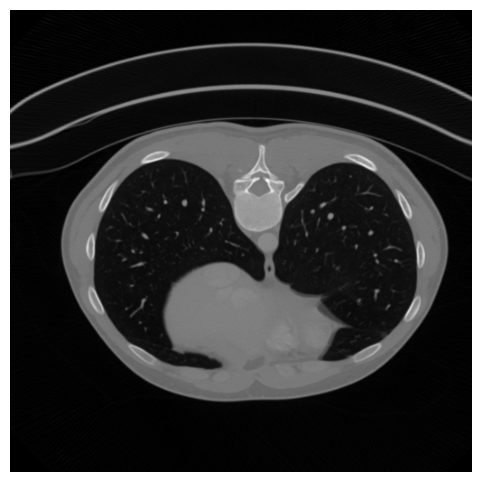

In [20]:
import ipywidgets as widgets
from IPython.display import display

# Create a dropdown widget for selecting a DICOM file
dropdown = widgets.Dropdown(
    options=dicom_files,
    description='Select DICOM:',
    disabled=False,
)

def on_select_change(change):
    visualize_dicom(bucket_name, change['new'])

# Set up the observer for the dropdown selection
dropdown.observe(on_select_change, names='value')

# Display the dropdown widget
display(dropdown)


## Create sliders for contrast and brightness

In [21]:
import numpy as np


contrast_slider = widgets.FloatSlider(
    value=1.0,
    min=0.5,
    max=2.0,
    step=0.1,
    description='Contrast:',
    continuous_update=False
)

brightness_slider = widgets.FloatSlider(
    value=0.0,
    min=-100,
    max=100,
    step=10,
    description='Brightness:',
    continuous_update=False
)

def update_image(change):
    dicom_data, _ = download_dicom_file(bucket_name, dropdown.value)
    image = dicom_data.pixel_array
    adjusted_image = np.clip(contrast_slider.value * image + brightness_slider.value, 0, 255)

    plt.figure(figsize=(6, 6))
    plt.imshow(adjusted_image, cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

contrast_slider.observe(update_image, names='value')
brightness_slider.observe(update_image, names='value')

display(contrast_slider, brightness_slider)


FloatSlider(value=1.0, continuous_update=False, description='Contrast:', max=2.0, min=0.5)

FloatSlider(value=0.0, continuous_update=False, description='Brightness:', min=-100.0, step=10.0)

## Histogram of Pixel Intensity 

In [23]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Create a button to display the histogram
histogram_button = widgets.Button(description="Show Histogram")
histogram_output = widgets.Output()

def show_histogram(b):
    dicom_data, error = download_dicom_file(bucket_name, dropdown.value)
    if error:
        print(f"Error downloading DICOM file: {error}")
    else:
        # Get pixel array from the DICOM file
        pixel_array = dicom_data.pixel_array
        
        # Display histogram
        with histogram_output:
            histogram_output.clear_output()
            plt.figure(figsize=(6, 4))
            plt.hist(pixel_array.ravel(), bins=256, color='gray', alpha=0.75)
            plt.title('Pixel Intensity Histogram')
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Frequency')
            plt.show()

histogram_button.on_click(show_histogram)

display(histogram_button, histogram_output)


Button(description='Show Histogram', style=ButtonStyle())

Output()

## Image Overlay ( best initial try)

In [24]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Create dropdown widgets for selecting two DICOM files
dropdown1 = widgets.Dropdown(
    options=dicom_files,
    description='DICOM 1:',
    disabled=False,
)

dropdown2 = widgets.Dropdown(
    options=dicom_files,
    description='DICOM 2:',
    disabled=False,
)

# Create a button to overlay the images
overlay_button = widgets.Button(description="Overlay Images")
overlay_output = widgets.Output()

def overlay_images(b):
    dicom_data1, error1 = download_dicom_file(bucket_name, dropdown1.value)
    dicom_data2, error2 = download_dicom_file(bucket_name, dropdown2.value)
    
    if error1 or error2:
        print(f"Error downloading DICOM files: {error1 or error2}")
    else:
        image1 = dicom_data1.pixel_array
        image2 = dicom_data2.pixel_array
        
        image1 = image1 / np.max(image1)
        image2 = image2 / np.max(image2)
        
        overlay = (image1 + image2) / 2
        
        with overlay_output:
            overlay_output.clear_output()
            plt.figure(figsize=(6, 6))
            plt.imshow(overlay, cmap=plt.cm.gray)
            plt.title(f"Overlay of {dropdown1.value} and {dropdown2.value}")
            plt.axis('off')
            plt.show()


overlay_button.on_click(overlay_images)
display(dropdown1, dropdown2, overlay_button, overlay_output)


Dropdown(description='DICOM 1:', options=('1-001.dcm', '1-002.dcm', '1-003.dcm', '1-004.dcm', '1-005.dcm', '1-…

Dropdown(description='DICOM 2:', options=('1-001.dcm', '1-002.dcm', '1-003.dcm', '1-004.dcm', '1-005.dcm', '1-…

Button(description='Overlay Images', style=ButtonStyle())

Output()

## Overlay with dropdown selection for colormap

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import ipywidgets as widgets
from IPython.display import display

custom_cmap = colors.LinearSegmentedColormap.from_list(
    'custom_cool', ['#0000FF', '#FF0000']  # From blue to red
)

dropdown1 = widgets.Dropdown(
    options=dicom_files,
    description='DICOM 1:',
    disabled=False,
)

dropdown2 = widgets.Dropdown(
    options=dicom_files,
    description='DICOM 2:',
    disabled=False,
)

# Create dropdown colormap selection
colormap_dropdown = widgets.Dropdown(
    options={'Gray': 'gray', 'Cool': 'cool', 'Hot': 'hot', 'Custom Cool': custom_cmap},
    value='gray',  # Default to 'gray'
    description='Colormap:',
)

difference_button = widgets.Button(description="Overlay Differences")
difference_output = widgets.Output()

def show_difference_image(b):
    dicom_data1, error1 = download_dicom_file(bucket_name, dropdown1.value)
    dicom_data2, error2 = download_dicom_file(bucket_name, dropdown2.value)
    
    if error1 or error2:
        print(f"Error downloading DICOM files: {error1 or error2}")
    else:
        image1 = dicom_data1.pixel_array
        image2 = dicom_data2.pixel_array
        
        difference_image = np.abs(image1 - image2)

        with difference_output:
            difference_output.clear_output()
            plt.figure(figsize=(6, 6))
            plt.imshow(difference_image, cmap=colormap_dropdown.value)
            plt.title(f"Difference Image of {dropdown1.value} and {dropdown2.value}")
            plt.axis('off')
            plt.show()

difference_button.on_click(show_difference_image)
display(dropdown1, dropdown2, colormap_dropdown, difference_button, difference_output)


Dropdown(description='DICOM 1:', options=('1-001.dcm', '1-002.dcm', '1-003.dcm', '1-004.dcm', '1-005.dcm', '1-…

Dropdown(description='DICOM 2:', options=('1-001.dcm', '1-002.dcm', '1-003.dcm', '1-004.dcm', '1-005.dcm', '1-…

Dropdown(description='Colormap:', options={'Gray': 'gray', 'Cool': 'cool', 'Hot': 'hot', 'Custom Cool': <matpl…

Button(description='Overlay Differences', style=ButtonStyle())

Output()